<p><font size="6" color='grey'> <b>
Generative KI
</b></font> </br></p>

<p><font size="5" color='grey'> <b>
Word Embeddings für eine Multi-Label-Klassifizierung
</b></font> </br></p>



---

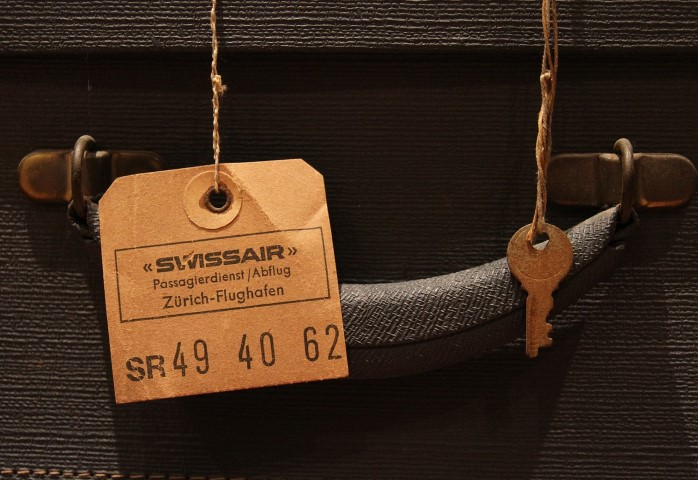

Bild von <a href="https://pixabay.com/de/users/monicavolpin-1476511/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=1205231">Monica Volpin</a> auf <a href="https://pixabay.com/de//?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=1205231">Pixabay</a>

# **1 | Setup und Installation**
---

Requirements Installation

In [ ]:
%%writefile requirements.txt
langchain-openai>=0.0.2
numpy>=1.24.3
openai>=1.0.0
pandas>=2.0.3
scikit-learn>=1.3.0

In [ ]:
!pip install -q -U -r requirements.txt

Imports

In [ ]:
# Standard Library
import os
import warnings

# Third Party
import numpy as np
import pandas as pd
from google.colab import userdata
from langchain_openai import OpenAIEmbeddings
from sklearn.metrics.pairwise import cosine_similarity

# Disable warnings
warnings.filterwarnings('ignore')

# **2 | Konfiguration und Umgebungsvariablen**
---



API-Konfiguration

In [ ]:
# OpenAI API Configuration
OPENAI_API_KEY = userdata.get('OpenAI-API-Key')
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# Model Configuration
EMBEDDING_MODEL = "text-embedding-3-small"
TOP_N_CATEGORIES = 2  # Anzahl der Top-Kategorien pro Kurs

# **3 | Datenvorverarbeitung**
---



Daten Laden

In [ ]:
# Download Datendateien von GitHub
!curl -L https://raw.githubusercontent.com/ralf-42/ML_Intro/main/02%20data/Lerninhalte.xlsx -o Lerninhalte.xlsx
!curl -L https://raw.githubusercontent.com/ralf-42/ML_Intro/main/02%20data/Kategorien.xlsx -o Kategorien.xlsx

# Daten in DataFrames laden
lerninhalte_df = pd.read_excel('Lerninhalte.xlsx')
kategorien_df = pd.read_excel('Kategorien.xlsx')

# Texte als Listen extrahieren
kurstitel_list = lerninhalte_df['Kurstitel'].tolist()
kategorie_list = kategorien_df['Kategorie'].tolist()

# **4 | Embedding-Modell**
---


Modell-Setup

In [ ]:
def setup_embedding_model():
    """Initialisiert das OpenAI Embedding-Modell."""
    return OpenAIEmbeddings(model=EMBEDDING_MODEL)

embeddings = setup_embedding_model()

Embedding-Funktionen

In [ ]:
def get_embeddings_for_texts(texts):
    """
    Erstellt Embeddings für eine Liste von Texten.

    Args:
        texts: Liste von Texten
    Returns:
        Liste von Embedding-Vektoren
    """
    return [embeddings.embed_query(text) for text in texts]

Embedding-Erstellung

In [ ]:
# Embeddings für Kurstitel und Kategorien erstellen
embeddings_kurstitel = get_embeddings_for_texts(kurstitel_list)
embeddings_kategorie = get_embeddings_for_texts(kategorie_list)

# Embeddings in DataFrames speichern
embeddings_kurstitel_df = pd.DataFrame({
    'Kurstitel': kurstitel_list,
    'Embedding': embeddings_kurstitel
})

embeddings_kategorie_df = pd.DataFrame({
    'Kategorie': kategorie_list,
    'Embedding': embeddings_kategorie
})

# **5 | Multi-Label-Klassifizierung**
---



Klassifizierungsfunktion

In [ ]:
def classify_courses():
    """
    Klassifiziert Kurse basierend auf Embedding-Ähnlichkeiten.

    Returns:
        DataFrame mit Kurstitel und zugeordneten Kategorien
    """
    result_df = pd.DataFrame(columns=["Kurstitel", "Kategorien"])

    for kurstitel in kurstitel_list:
        # Kurstitel Embedding abrufen
        kurstitel_embedding = embeddings_kurstitel_df.Embedding[
            (embeddings_kurstitel_df['Kurstitel'] == kurstitel)
        ]

        # Ähnlichkeitsberechnung
        kategorie_matrix = np.array(embeddings_kategorie_df['Embedding'].tolist())
        kurstitel_matrix = np.array(kurstitel_embedding.tolist())
        similarities = cosine_similarity(kategorie_matrix, kurstitel_matrix)

        # Top-Kategorien auswählen
        similarities_df = pd.DataFrame(similarities, columns=['Similarity'])
        top_n_df = similarities_df.sort_values(
            by='Similarity',
            ascending=False
        ).head(TOP_N_CATEGORIES)

        kategorie_list = np.array(
            kategorien_df.loc[top_n_df.index]
        ).flatten().tolist()

        # Ergebnis speichern
        result_df.loc[len(result_df)] = {
            "Kurstitel": kurstitel,
            "Kategorien": kategorie_list
        }

    return result_df

Klassifizierung durchführen

In [ ]:
# Klassifizierung durchführen
result_df = classify_courses()

# Ergebnis speichern
result_df.to_excel('result_df.xlsx', index=False)

# **6 | Ergebnisse**

In [ ]:
print("Form der Embeddings:", embeddings_kurstitel[0].shape)
print("\nBeispiel-Klassifizierungen:")
print(result_df.head())